In [1]:
# !pip install simpy
# !pip install numpy pandas

In [2]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta


## Creating Virtual sensors because cant afford one

In [3]:
def soil_moisture_sensor(env, data, interval=1):
    while True:
        moisture = np.random.normal(18, 5)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        data.append(('Soil Moisture', timestamp, moisture))
        yield env.timeout(interval)
        time.sleep(interval)  # Simulate real-time delay

def temperature_sensor(env, data, interval=1):
    while True:
        temperature = np.random.normal(30, 3)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        data.append(('Temperature', timestamp, temperature))
        yield env.timeout(interval)
        time.sleep(interval)  # Simulate real-time delay

def crop_growth_sensor(env, data, interval=5):
    growth_stage = 0
    while True:
        growth_stage += np.random.normal(0.1, 0.05)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        data.append(('Crop Growth', timestamp, growth_stage))
        yield env.timeout(interval)
        time.sleep(interval)  # Simulate real-time delay

**An interval is a measure of how frequently sensor readings are taken, specified as the number of readings per minute.**

*Soil moist sensor average moist in soil is 18 because we considered highest agricultrual state of India Uttar Pradesh. Where few documantation provided the average moist in UP is 18 wtih standard deviation of 5 and average temprature of 30 with standard deviation of 3.*

In [4]:
def evapotranspiration_virtual_sensor(data):
    df = pd.DataFrame(data, columns=['Sensor', 'Time', 'Value'])
    
    # Pivot the data to align timestamps
    pivot_df = df.pivot_table(index='Time', columns='Sensor', values='Value', aggfunc='mean').reset_index()

    # Interpolate missing values to fill NaNs
    pivot_df.interpolate(method='linear', inplace=True)

    et_data = []
    for _, row in pivot_df.iterrows():
        if not pd.isna(row['Soil Moisture']) and not pd.isna(row['Temperature']):
            et = 0.0023 * (row['Temperature'] + 17.8) * np.sqrt(row['Soil Moisture'] / 100)
            et_data.append(('Evapotranspiration', row['Time'], et))

    return et_data


In [5]:
def run_real_time_simulation(duration):
    # Set up the simulation environment
    env = simpy.Environment()
    data = []

    # Start the sensors
    env.process(soil_moisture_sensor(env, data))
    env.process(temperature_sensor(env, data))
    env.process(crop_growth_sensor(env, data))

    # Run the simulation
    start_time = time.time()
    while time.time() - start_time < duration:
        env.run(until=env.now + 1)

    # Process the collected data
    et_data = evapotranspiration_virtual_sensor(data)
    data.extend(et_data)

    # Convert data to DataFrame for easier analysis
    df = pd.DataFrame(data, columns=['Sensor', 'Time', 'Value'])

    # Print the DataFrame
    print(df)

    # Save data to a CSV file
    df.to_csv('sensor_data.csv', index=False)


In [6]:
run_real_time_simulation(20)

                Sensor                 Time      Value
0        Soil Moisture  2024-05-24 07:59:41  19.519852
1          Temperature  2024-05-24 07:59:41  31.476835
2          Crop Growth  2024-05-24 07:59:41   0.159983
3        Soil Moisture  2024-05-24 07:59:42  10.369099
4          Temperature  2024-05-24 07:59:43  29.604507
5        Soil Moisture  2024-05-24 07:59:44  15.991120
6          Temperature  2024-05-24 07:59:45  33.651963
7        Soil Moisture  2024-05-24 07:59:46  12.482664
8          Temperature  2024-05-24 07:59:47  34.035573
9        Soil Moisture  2024-05-24 07:59:48  19.417958
10         Temperature  2024-05-24 07:59:49  26.069394
11         Crop Growth  2024-05-24 07:59:54   0.199817
12       Soil Moisture  2024-05-24 07:59:55  13.480434
13         Temperature  2024-05-24 07:59:56  30.147169
14       Soil Moisture  2024-05-24 07:59:57  18.023320
15         Temperature  2024-05-24 07:59:58  33.160074
16       Soil Moisture  2024-05-24 07:59:59  24.030988
17        

/tmp/ipykernel_5461/588546501.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  pivot_df.interpolate(method='linear', inplace=True)


In [12]:
df1=pd.read_csv("sensor_data.csv")
grouped_df = df1.groupby('Sensor')['Value'].mean()

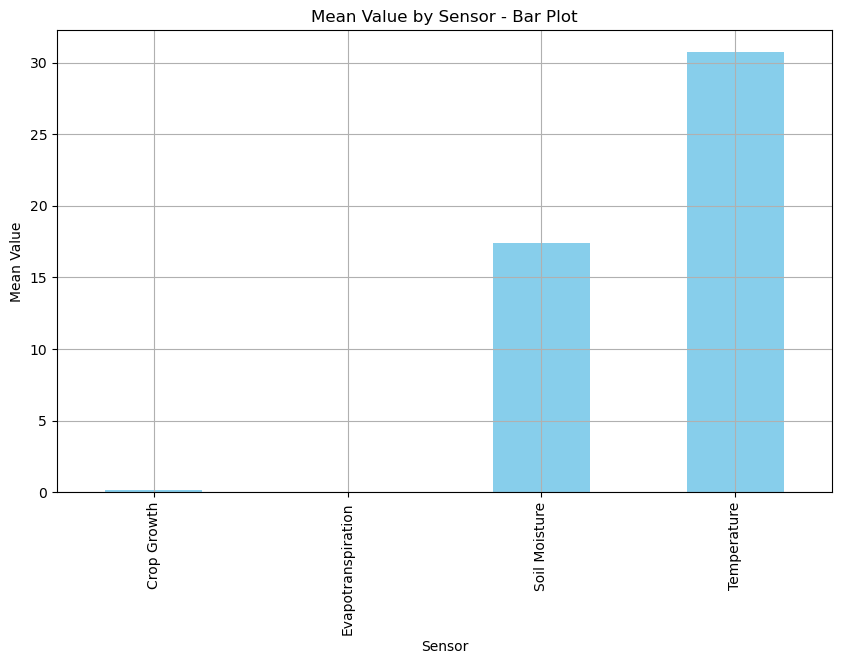

In [13]:
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='bar', color='skyblue')
plt.title('Mean Value by Sensor - Bar Plot')
plt.xlabel('Sensor')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()

This bar graph shows the mean of sensor readings where the mean of temperature is 30.72. Soil moisture readings 17.43. 
Where as the readings of crop growth and evapotranspiration is very less which cant be seen in the plot

In [17]:
grouped_df

Sensor
Crop Growth            0.179900
Evapotranspiration     0.046346
Soil Moisture         17.437767
Temperature           30.726643
Name: Value, dtype: float64

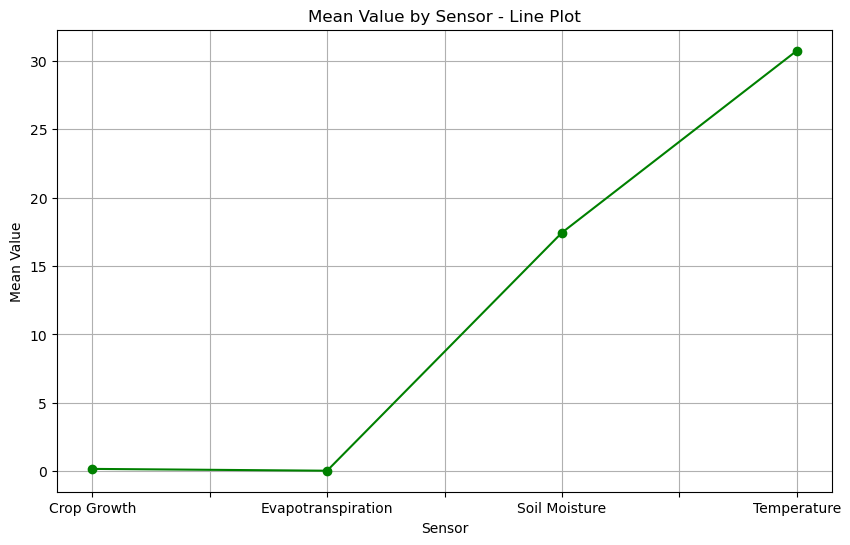

In [14]:
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='line', marker='o', linestyle='-', color='green')
plt.title('Mean Value by Sensor - Line Plot')
plt.xlabel('Sensor')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()

The x-axis of the graph is labeled "Evapotranspiration" with values likely ranging from 0 to 25. The y-axis of the graph is labeled "Mean Value" with values ranging from 0 to 30.

There is a single line plotted on the graph. The line slopes upwards from left to right, indicating that as the evapotranspiration value increases, the mean value also increases. This suggests a positive correlation between crop growth and evapotranspiration.

<Figure size 1000x600 with 0 Axes>

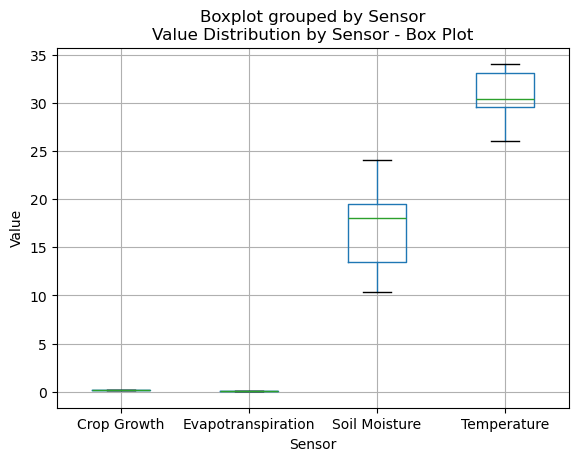

In [15]:
plt.figure(figsize=(10, 6))
df1.boxplot(column='Value', by='Sensor')
plt.title('Value Distribution by Sensor - Box Plot')
plt.xlabel('Sensor')
plt.ylabel('Value')
plt.grid(True)
plt.show()

The x-axis of the graph is labeled "Sensor" and lists the four sensors mentioned above. The y-axis of the graph is labeled "Value" and likely represents the measurement scale for each sensor.

For each sensor on the x-axis, there is a boxplot. The box in the plot represents the interquartile range (IQR) of the data, with the line in the middle of the box representing the median value. The whiskers extend from the top and bottom of the box to the most extreme data points within 1.5 times the IQR from the median. Points beyond the whiskers are considered outliers and are plotted individually.

By looking at the relative positions of the boxes and outliers, we can visually compare the distributions of the values for each sensor. For example, the box for crop growth appears to be higher on the y-axis than the boxes for the other sensors, which could indicate that crop growth values tend to be higher in general.


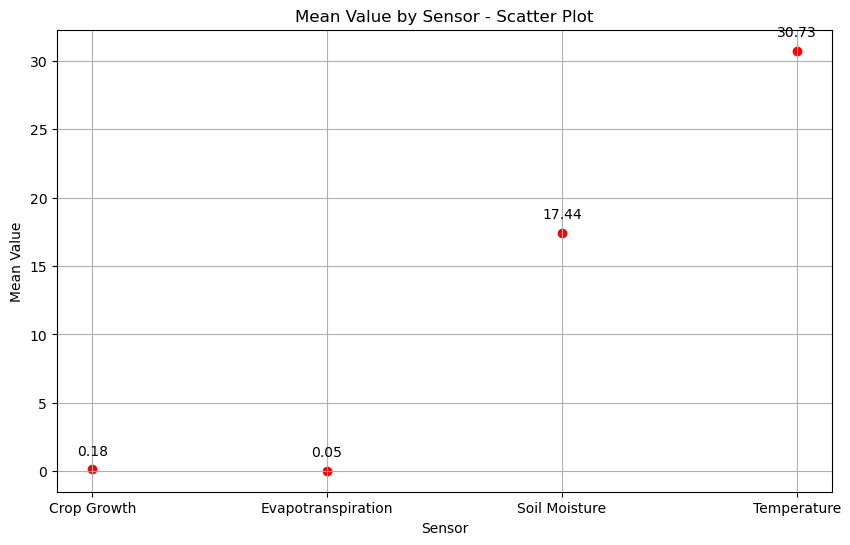

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df.index, grouped_df.values, color='red')
for i, txt in enumerate(grouped_df.values):
    plt.annotate(f'{txt:.2f}', (grouped_df.index[i], grouped_df.values[i]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Mean Value by Sensor - Scatter Plot')
plt.xlabel('Sensor')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()

The x-axis of the graph is labeled "Sensor" and lists four categories: "Crop Growth", "Evapotranspiration", "Soil Moisture", and "Temperature".

The y-axis of the graph is labeled "Mean Value" with values ranging from 0 to 30.

There are four data points plotted on the graph, each representing a sensor. The data points are circles and their colors correspond to the sensor category listed on the x-axis. For example, the blue circle is for "Crop Growth" and the green circle is for "Evapotranspiration".

The position of each data point along the x-axis indicates the sensor it represents and its position on the y-axis indicates the mean value measured by that sensor. For instance, the blue circle ("Crop Growth") is the highest data point on the y-axis, meaning it has the highest mean value.